# Titanic Survivor Prediction
The classic Kaggle compettition, demonstrating basic data science techniques.  Data from https://www.kaggle.com/c/titanic/data

In [22]:
# Imports

import os
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# machine learning
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


## Load and Preview data
kaggle provides data split into train/test sets. In this case, the test set is unlabeled.  The intention is to make predictions on the test set and submit them to kaggle for scoring. 

In [2]:
train_df = pd.read_csv(os.path.join('data', "train.csv"))
test_df = pd.read_csv(os.path.join('data', "test.csv"))
train_df.info()
print('----------------')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           4

In [3]:
''' Some initial thoughts: right off the bat we see that `Cabin` only has 204 values.  While this information
could be of value, `Pclass` should give us the same type of information so we will drop it.

`PassengerId` and `Ticket` number should also not be relavent to our analysis'''
drop_features = ['Cabin','PassengerId','Ticket']
train_df = train_df.drop(drop_features, axis=1)
test_df = test_df.drop(drop_features, axis=1)

''' `Age` and `Fare` both have missing values.  We can fill in missing values with the mean of the values from the 
train set'''
train_df['Age'] = train_df['Age'].fillna(train_df['Age'].mean())
test_df['Age'] = test_df['Age'].fillna(train_df['Age'].mean())
test_df['Fare'] = test_df['Fare'].fillna(train_df['Fare'].mean())

'''`Embarked` is missing just two values. Since this is a categorical feature representing the port of Embarkation
 we cannot use a mean value and will just choose to fill it with `S` ''' 
train_df['Embarked'] = train_df['Embarked'].fillna('S')

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         891 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Embarked    891 non-null object
dtypes: float64(2), int64(4), object(3)
memory usage: 62.7+ KB


## Data Visuals
Plot survival rate against some of the features

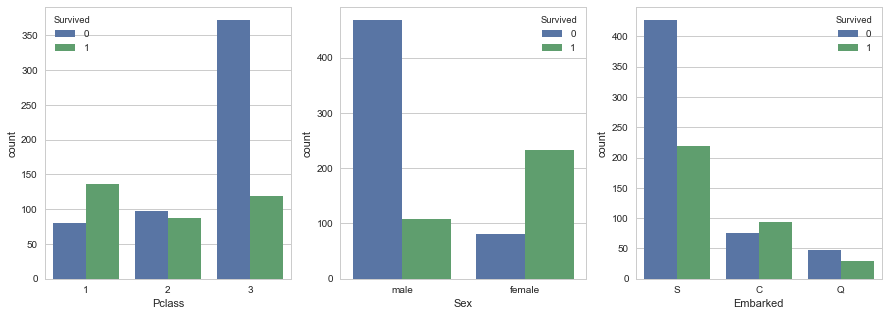

In [5]:
'''Plot the `Survived` counts for Categorial features'''
cat_features = ['Pclass','Sex','Embarked']
fig, axs = plt.subplots(ncols=len(cat_features),figsize=(15,5))
for index,item in enumerate(cat_features):
    sns.countplot(train_df[item], hue=train_df['Survived'],ax=axs[index])

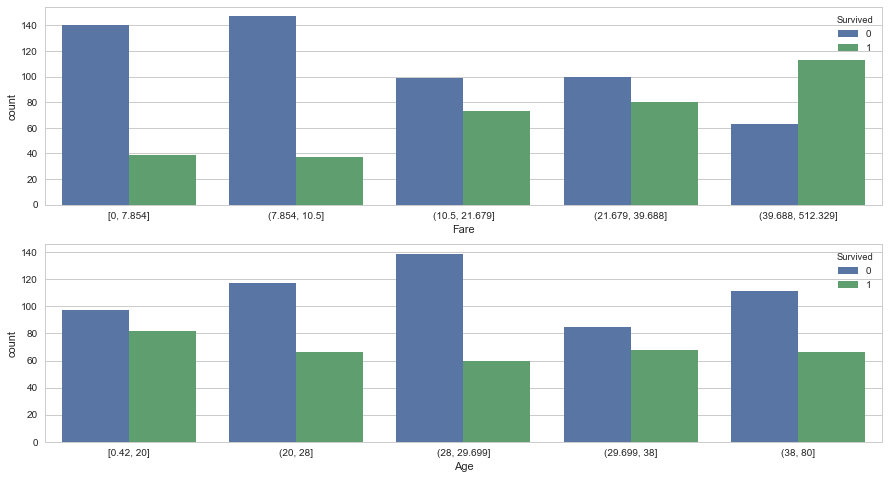

In [6]:
'''Features with more continuous by nature values can be binned and plotted in a similar fashion'''
fig, axs = plt.subplots(nrows=2,figsize=(15,8))
#for index,item in enumerate(cat_features):
sns.countplot(pd.qcut(train_df['Fare'],5), hue=train_df['Survived'],ax=axs[0])
sns.countplot(pd.qcut(train_df['Age'],5), hue=train_df['Survived'],ax=axs[1])



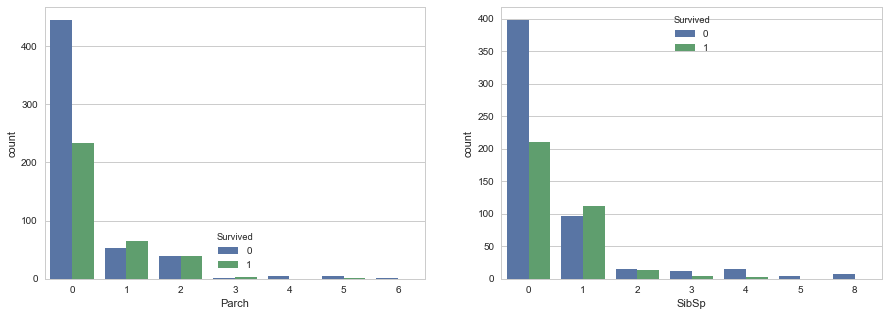

In [7]:
'''Finally, `Parch` and `SibSp`, the number of parents and siblings, respectively, have only a few discrete values
and therefore don't need binning '''
fig, axs = plt.subplots(ncols=2,figsize=(15,5))
sns.countplot(train_df['Parch'], hue=train_df['Survived'],ax=axs[0])
sns.countplot(train_df['SibSp'], hue=train_df['Survived'],ax=axs[1])

## Further Feature Engineering
There is still one feature we have neglected, `Name`.  As is, `Name` seems like a useless feature. Is there any information we can extract from `Name`?

['Mr.' 'Mrs.' 'Miss.' 'Master.' 'Don.' 'Rev.' 'Dr.' 'Mme.' 'Ms.' 'Major.'
 'Lady.' 'Sir.' 'Mlle.' 'Col.' 'Capt.' 'the' 'Jonkheer.']


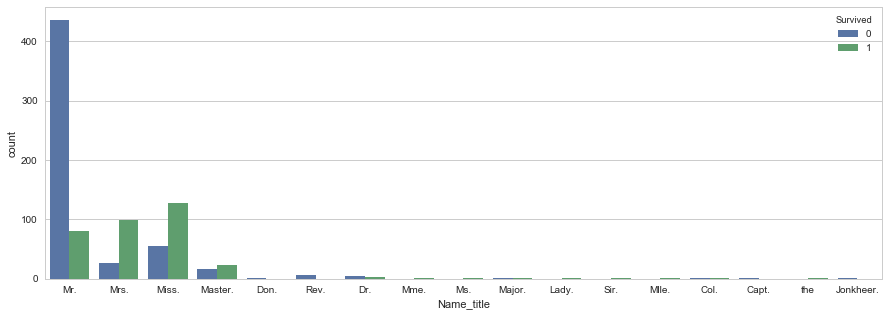

In [8]:
''' For example, we can isolate the title from each name.  It appears you are more likely to survive if you are a
"Mrs", "Miss" or "Master" '''
train_df['Name_title']= train_df['Name'].apply(lambda x: x.split(',')[1])
train_df['Name_title']= train_df['Name_title'].apply(lambda x: x.split()[0])
print(train_df['Name_title'].unique())
plt.figure(figsize=(15,5)) 
sns.countplot(train_df['Name_title'], hue=train_df['Survived'])
plt.show()

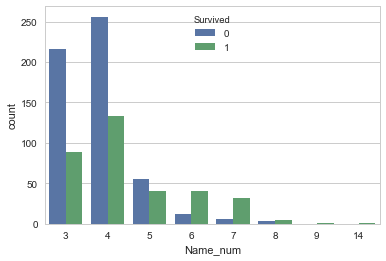

In [9]:
'''what about, simply, the number of words one has in their name? If one has more titles and middle names perhaps
they are more likely to be saved?'''
train_df['Name_num'] = train_df['Name'].apply(lambda x: x.split())
train_df['Name_num'] = train_df['Name_num'].apply(lambda x: len(x))
sns.countplot(train_df['Name_num'], hue=train_df['Survived'])

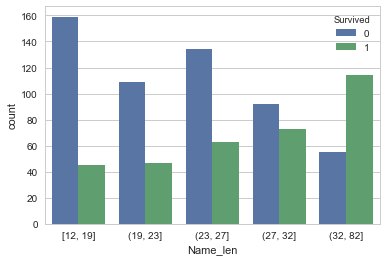

In [10]:
'''Finally, maybe the total length (number of characters) can tell us something'''
train_df['Name_len'] = train_df['Name'].apply(lambda x: len(x))
sns.countplot(pd.qcut(train_df['Name_len'],5), hue=train_df['Survived'])

In [11]:
'''Now that we have gotten what we need out of `Name` we can drop it from the dataframes. '''
train_df = train_df.drop(['Name'],axis=1)
'''Add the new features to the test set'''
test_df['Name_title']= test_df['Name'].apply(lambda x: x.split(',')[1])
test_df['Name_title']= test_df['Name_title'].apply(lambda x: x.split()[0])
test_df['Name_num'] = test_df['Name'].apply(lambda x: x.split())
test_df['Name_num'] = test_df['Name_num'].apply(lambda x: len(x))
test_df['Name_len'] = test_df['Name'].apply(lambda x: len(x))
test_df = test_df.drop(['Name'],axis=1)

In [12]:
print(train_df.shape)
print(test_df.shape)

(891, 11)
(418, 10)


## Final Preprocessing
Now that we have all the features we need we are almost ready to start using them to train algorithms and make predictions about passenger survival. The last step before this is to make sure the data is in the correct format. This envolve transforming categorical data into boolean values using dummy variables, and using standardized scaling to ensure all features are on the same scale.

In [14]:
''' to get the remaining features on the same scale, lets seperate the dummy features from the rest '''
# seperate predictor, `Survived` and reshape for sklearn use. drop from main data frame
y_train = train_df[['Survived']].as_matrix()
r,c = y_train.shape
y_train = y_train.reshape(r,)
train_df = train_df.drop(['Survived'],axis=1,errors="ignore")

In [15]:
'''first lets deal with the categorical feature'''

# create dummy features for categorical features, save new feature names to a new list
categorical_features = ['Name_title','Pclass','Sex','Embarked']
# the rest of the features we will call scale_features, as later then will need to be standarized
scale_features = [val for val in list(train_df.columns) if val not in categorical_features]
# create empty lists for collect the names of the created dummy features
dummy_feature_tr = []
dummy_feature_te = []
for feature in categorical_features:
    #create dummy categories for the categorical feature
    temp_df_tr = pd.get_dummies(train_df[feature],prefix=feature)
    temp_df_te = pd.get_dummies(test_df[feature],prefix=feature)
    #append the list of dummy features 
    dummy_feature_tr.append(list(temp_df_tr.columns))
    dummy_feature_te.append(list(temp_df_te.columns))
    #collect dummy features in a single dataframe
    train_df = pd.concat([train_df,temp_df_tr], axis=1)
    test_df = pd.concat([test_df,temp_df_te], axis=1)

#flatten list of new dummy feature names
dummy_feature_tr = [item for sublist in dummy_feature_tr for item in sublist]  
dummy_feature_te = [item for sublist in dummy_feature_te for item in sublist]  

'''its important that test and train have the same number of features. This may not be the case, specifically for the
the dummy features created for `Name_title`. To take care of this, for now, we will simply drop the dummy features
which tare not in both data sets'''

# list the features which exsist in both list of dummy_features.  
dummy_features = [val for val in dummy_feature_tr if val in dummy_feature_te]
# file data frames with all the features that will be used in the training and testing the model
train_df = train_df[dummy_features + scale_features]
test_df = test_df[dummy_features + scale_features]
#print out shapes as a check
print(train_df.shape,", ",test_df.shape)

(891, 22) ,  (418, 22)


# Predictions
We will set aside the provided test data for now. Since it is unlabeled it is useless for testing how well our trained model is performing. We do need to split our training data into training and testing sets though.

In [16]:
# split the full train set in train and test, ensuring an equal proportion of "survives" in each set
X_train,X_test,y_train,y_test = train_test_split(train_df,y_train,test_size=0.3,random_state=1,stratify = y_train)
print(y_train.mean(),',',y_test.mean())

#Standarize the non categorical features. First seperate out the dummy features since we dont want to standarize them
X_train_dummy = X_train[dummy_features]; X_test_dummy = X_test[dummy_features]
X_train = X_train.drop(dummy_features,axis=1); X_test = X_test.drop(dummy_features,axis=1)
#fit the standardscaler to the training set
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
#recombine training sets
X_train_final = np.concatenate((X_train_scaled,X_train_dummy),axis=1)
#scale test set using training fits
X_test_scaled = scaler.transform(X_test)
#recombine
X_test_final = np.concatenate((X_test_scaled,X_test_dummy),axis=1)
print(X_train_final.shape,", ",X_test_final.shape)


0.383627608347 , 0.384328358209
(623, 22) ,  (268, 22)


In [17]:
''' Lets write some functions for computing the results so we can easily compare different models, feature selections, etc
'''
def compute_false_negatives(target, predictions):
    # rate at which model predicts a 0 but target hould be a 1
    df = pd.DataFrame({"target": target, "predictions": predictions})
    return df[(df["target"] == 1) & (df["predictions"] == 0)].shape[0] / (df[(df["target"] == 1)].shape[0] + 1)

def compute_false_positives(target, predictions):
    # rate at which model predicts a 1 but target is a 0
    df = pd.DataFrame({"target": target, "predictions": predictions})
    return df[(df["target"] == 0) & (df["predictions"] == 1)].shape[0] / (df[(df["target"] == 0)].shape[0] + 1)

In [18]:
'''train a logistic regression model'''
clf = LogisticRegression(random_state=1, class_weight="balanced").fit(X_train_final, y_train)
predictions = clf.predict(X_test_final)
score = clf.score(X_test_final,y_test)
fn = compute_false_negatives(y_test, predictions)
fp = compute_false_positives(y_test, predictions)
print("Accuracy Score: {}".format(score))
print("False Negatives: {}".format(fn))
print("False Positives: {}".format(fp))

Accuracy Score: 0.8171641791044776
False Negatives: 0.22115384615384615
False Positives: 0.1566265060240964


In [20]:
'''We can look at the coefficients of the fit to see which features matter the most.  This can help us further
optimize our feature selection and can also give us a more intuitive picture of what is happening'''
coeff_df = pd.DataFrame(train_df.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(clf.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
8,Pclass_2,1.958546
14,Embarked_S,1.143235
17,Parch,1.119214
11,Sex_male,0.594417
19,Name_num,0.375092
9,Pclass_3,0.197853
3,Name_title_Mr.,0.183484
20,Name_len,0.169716
5,Name_title_Ms.,0.165176
15,Age,0.039027


## Let's try a Random Forest Classification
This in fact gives us a better score, which a much smaller false positives rate but, interestingly, a higher false negatives rate. why?

In [49]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train_final, y_train)
predictions = random_forest.predict(X_test_final)
score = random_forest.score(X_test_final, y_test)
fn = compute_false_negatives(y_test, predictions)
fp = compute_false_positives(y_test, predictions)
print("Accuracy Score: {}".format(score))
print("False Negatives: {}".format(fn))
print("False Positives: {}".format(fp))


Accuracy Score: 0.835820895522388
False Negatives: 0.2692307692307692
False Positives: 0.0963855421686747


In [50]:
'''Random forests keep track of importances as opposed to fit coefficients.'''
coeff_df = pd.DataFrame(train_df.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Importance"] = pd.Series(random_forest.feature_importances_)

coeff_df.sort_values(by='Importance', ascending=False)

,Feature,Importance
0,Name_title_Dr.,0.154998
3,Name_title_Mr.,0.154550
5,Name_title_Ms.,0.133631
18,Fare,0.093988
10,Sex_female,0.077805
17,Parch,0.060328
16,SibSp,0.052835
1,Name_title_Master.,0.048201
4,Name_title_Mrs.,0.046384
14,Embarked_S,0.031466


## Where to go from here?
- Further feature engineering? Can the above models help us come up with new and improved features?
- Try different learning algorithms?
- Think about the differences in the results of the two models. What can that tell us?
- Add in cross-validation